In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# Dataset root
DATASET_ROOT = "/content/drive/My Drive/Goslar_dataset_split"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
VAL_DIR   = os.path.join(DATASET_ROOT, "val")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 4
SEED = 42


In [ ]:

train_datagen = ImageDataGenerator(

    rotation_range=10,         # Slight rotation
    width_shift_range=0.1,     # Minimal horizontal shift
    height_shift_range=0.1,    # Minimal vertical shift
    horizontal_flip=True,      # Flips image (remove if direction matters, e.g., text)
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)



Found 1920 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


In [ ]:
from keras.regularizers import l2
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)


# Freeze all backbone layers (PHASE 1)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)

outputs = Dense(
    NUM_CLASSES,
    activation="softmax"
)(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=["accuracy"]
)


In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        "best_model_phase1.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3265 - loss: 1.4987
Epoch 1: val_loss improved from inf to 1.35322, saving model to best_model_phase1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.3274 - loss: 1.4978 - val_accuracy: 0.4750 - val_loss: 1.3532 - learning_rate: 0.0010
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.4580 - loss: 1.3230
Epoch 2: val_loss improved from 1.35322 to 1.31194, saving model to best_model_phase1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4582 - loss: 1.3229 - val_accuracy: 0.5167 - val_loss: 1.3119 - learning_rate: 0.0010
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5558 - loss: 1.2493
Epoch 3: val_loss improved from 1.31194 to 1.26124, saving model to best_model_phase1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5556 - loss: 1.2493 - val_accuracy: 0.5417 - val_loss: 1.2612 - learning_rate: 0.0010
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5464 - loss: 1.2116
Epoch 4: val_loss improved from 1.26124 to 1.25368, saving model to best_model_phase1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5464 - loss: 1.2117 - val_accuracy: 0.5375 - val_loss: 1.2537 - learning_rate: 0.0010
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5886 - loss: 1.1757
Epoch 5: val_loss improved from 1.25368 to 1.24077, saving model to best_model_phase1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5884 - loss: 1.1756 - val_accuracy: 0.5708 - val_loss: 1.2408 - learning_rate: 0.0010
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6164 - loss: 1.1296
Epoch 6: val_loss did not improve from 1.24077
60/60 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6164 - loss: 1.1297 - val_accuracy: 0.5417 - val_loss: 1.2626 - learning_rate: 0.0010
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6471 - loss: 1.0970
Epoch 7: val_loss did not improve from 1.24077
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6470 - loss: 1.0971 - val_accuracy: 0.5292 - val_loss: 1.2677 - learning_rate: 0.0010
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6278 - loss: 1.1031
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 8: val_loss did not improve from 1.24077
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6281 - loss: 1.1029 - val_accuracy: 0.5458 - val_loss: 1.2824 -

In [ ]:
# Unfreeze top layers of backbone
for layer in base_model.layers[-25:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=["accuracy"]
)


In [ ]:
callbacks_finetune = [
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        "best_model_finetuned.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks_finetune
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4735 - loss: 1.3668
Epoch 1: val_loss improved from inf to 1.25622, saving model to best_model_finetuned.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4735 - loss: 1.3667 - val_accuracy: 0.5250 - val_loss: 1.2562 - learning_rate: 1.0000e-05
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4847 - loss: 1.3049
Epoch 2: val_loss did not improve from 1.25622
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4845 - loss: 1.3054 - val_accuracy: 0.5083 - val_loss: 1.2783 - learning_rate: 1.0000e-05
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5072 - loss: 1.3094
Epoch 3: val_loss did not improve from 1.25622
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5071 - loss: 1.3096 - val_accuracy: 0.5042 - val_loss: 1.2907 - learning_rate: 1.0000e-05
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5078 - loss: 1.2805
Epoch 4: val_loss did not improve from 1.25622
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5078 - loss: 1.2807 - val_accuracy: 0.5125 - val_loss: 1.2964 - learning_rate: 1.0000e-05
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
def graph(history):
  import matplotlib.pyplot as plt
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  nepochs=len(history.history['loss'])
  plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
  plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='validation')
  plt.legend(prop={'size': 20})
  plt.ylabel('loss')
  plt.xlabel('# of epochs')
  plt.subplot(1,2,2)
  plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
  plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='validation')
  plt.legend(prop={'size': 20})
  plt.ylabel('accuracy')
  plt.xlabel('# of epochs')

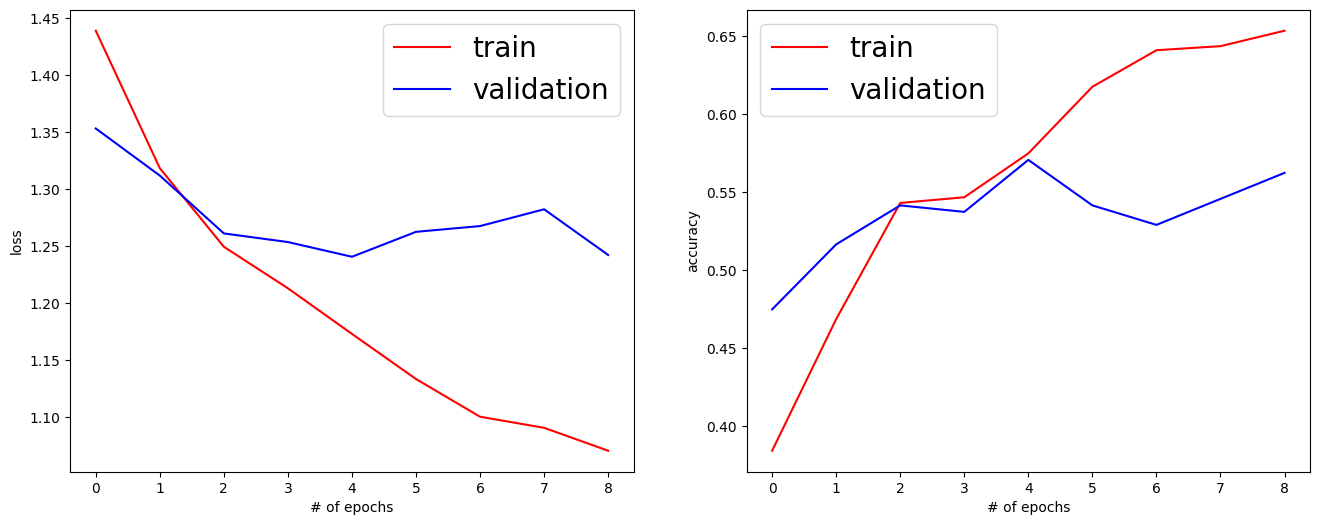

In [ ]:
graph(history_phase1)

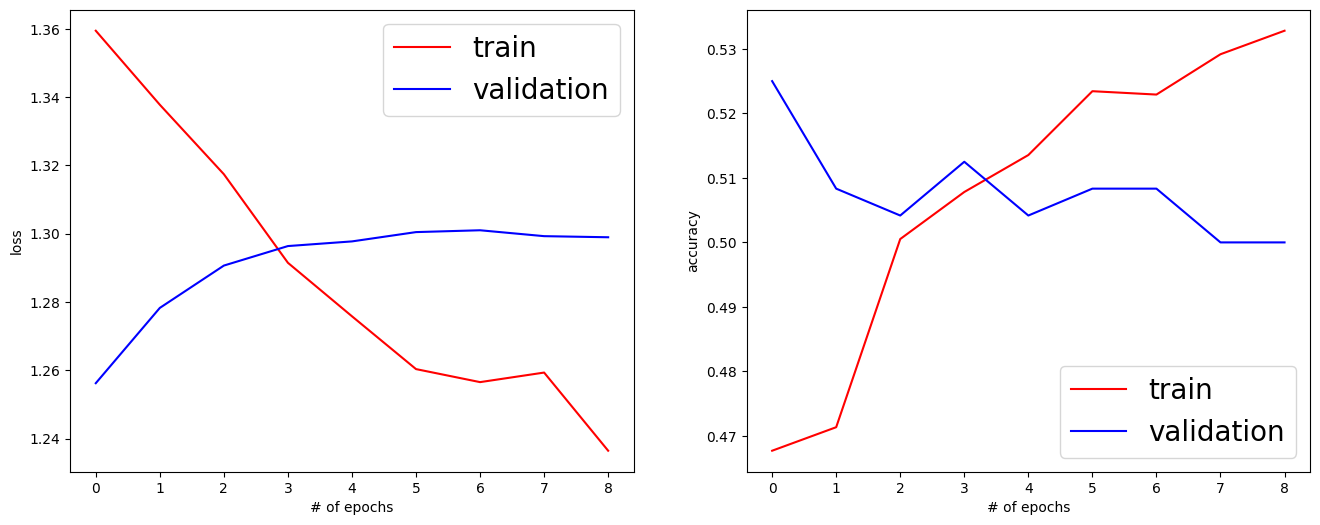

In [ ]:
graph(history_phase2)

In [ ]:
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 968ms/step - accuracy: 0.5916 - loss: 1.1971
Test accuracy: 0.5083333253860474
